# MALA proposal example: Rosenbrock Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import tinyDA as tda

In [2]:
np.random.seed(123)

### Defining the true model and generating some data

In [3]:
# Rosenbrock function.
def rosenbrock(x,y,a=1,b=10):
    return (a-x)**2 + b*(y-x**2)**2

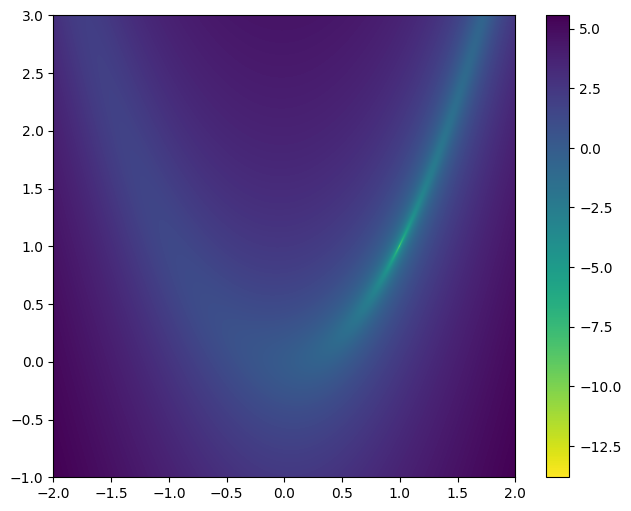

In [4]:
xx = np.linspace(-2,2, 1000); yy = np.linspace(-1,3, 1000); X, Y = np.meshgrid(xx,yy)
surf = rosenbrock(X,Y)

plt.figure(figsize = (8,6))
plt.imshow(np.log(surf), origin = 'lower', cmap = 'viridis_r', extent = [-2, 2, -1, 3]); plt.colorbar()
plt.show()

### Set up the statistical model

In [5]:
# set the prior
mean_prior = np.zeros(2)
cov_prior = np.eye(2)
my_prior = multivariate_normal(mean_prior, cov_prior)

# set the likelihood
y = np.array([0])
cov_likelihood = np.eye(y.shape[0])
my_loglike = tda.GaussianLogLike(y, cov_likelihood)

In [6]:
class MyModel:
    def __init__(self, model):
        self.model = model
    def __call__(self, parameters):
        return np.array([self.model(parameters[0], parameters[1])])
    def gradient(self, parameters, sensitivity):
        dFdx = 2*(20*parameters[0]**3 - 20*parameters[0]*parameters[1] + parameters[0] - 1)
        dFdy = 20*(parameters[1] - parameters[0]**2)
        jacobian = np.array([[dFdx, dFdy]])
        return np.dot(sensitivity, jacobian)

In [7]:
# initialise the model
my_model = MyModel(rosenbrock)

In [8]:
# initialise the Posterior
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

### Set up the proposal

In [9]:
mala_scaling = 0.01
mala_adaptive = True
my_proposal = tda.MALA(scaling=mala_scaling, adaptive=mala_adaptive)

### Sample

In [10]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 25000
    burnin = 5000

In [11]:
my_chains = tda.sample(my_posterior, my_proposal, iterations=iterations, n_chains=2)

Sampling 2 chains in parallel


2025-12-15 13:54:23,906	INFO worker.py:1786 -- Started a local Ray instance.


### Get some diagnostics

In [18]:
import arviz as az

In [13]:
idata = tda.to_inference_data(my_chains, burnin=burnin)

/home/louisekluge/miniconda3/envs/tda/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.457,0.388,-0.268,1.166,0.013,0.011,862.0,881.0,1.0
x1,0.340,0.420,-0.314,1.154,0.017,0.013,852.0,761.0,1.0


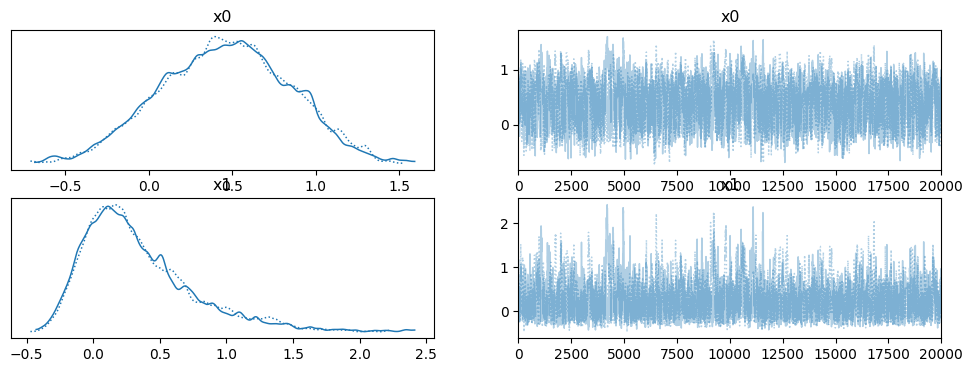

In [15]:
az.plot_trace(idata)
plt.show()

In [ ]:
parameters = np.array([link.parameters for link in my_chains['chain_0'][burnin:] + my_chains['chain_1'][burnin:]])

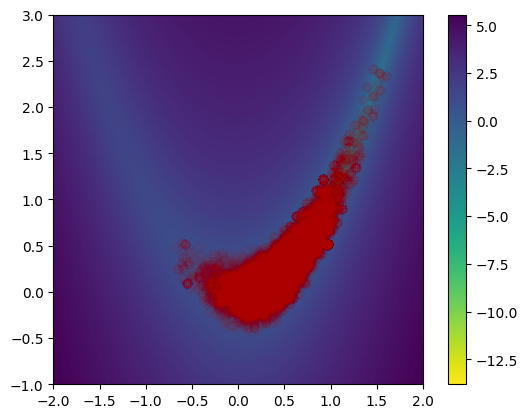

In [17]:
plt.imshow(np.log(surf), origin = 'lower', cmap = 'viridis_r', extent = [-2, 2, -1, 3]); plt.colorbar()
plt.scatter(parameters[:,0], parameters[:,1], c='red', alpha=0.01)
plt.show()